In [1]:
import os
WM_PROJECT_USER_DIR=os.environ['WM_PROJECT_USER_DIR']
import sys 
sys.path.append(f"{WM_PROJECT_USER_DIR}/utilities")
import numpy as np
import pandas as pd
import postProcess.polyMesh2d as mesh2d
import postProcess.pyResconstruct as pyResconstruct
import postProcess.pyFigure as pyFigure
import postProcess.pyCompute as pyCompute
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import json
import proplot as plot
import concurrent.futures

%load_ext autoreload
%autoreload 2


In [2]:
df_rate_external=pd.read_csv("../T673_Pe1e-3_ExternalSurface/postProcess/others/ReactionRateAndBurningRate.csv")
df_rate_external.sort_values(by="time",inplace=True)
df_rate_rpm=pd.read_csv("../T673_Pe1e-3_modifiedRPM/postProcess/others/ReactionRateAndBurningRate.csv")
df_rate_rpm.sort_values(by="time",inplace=True)

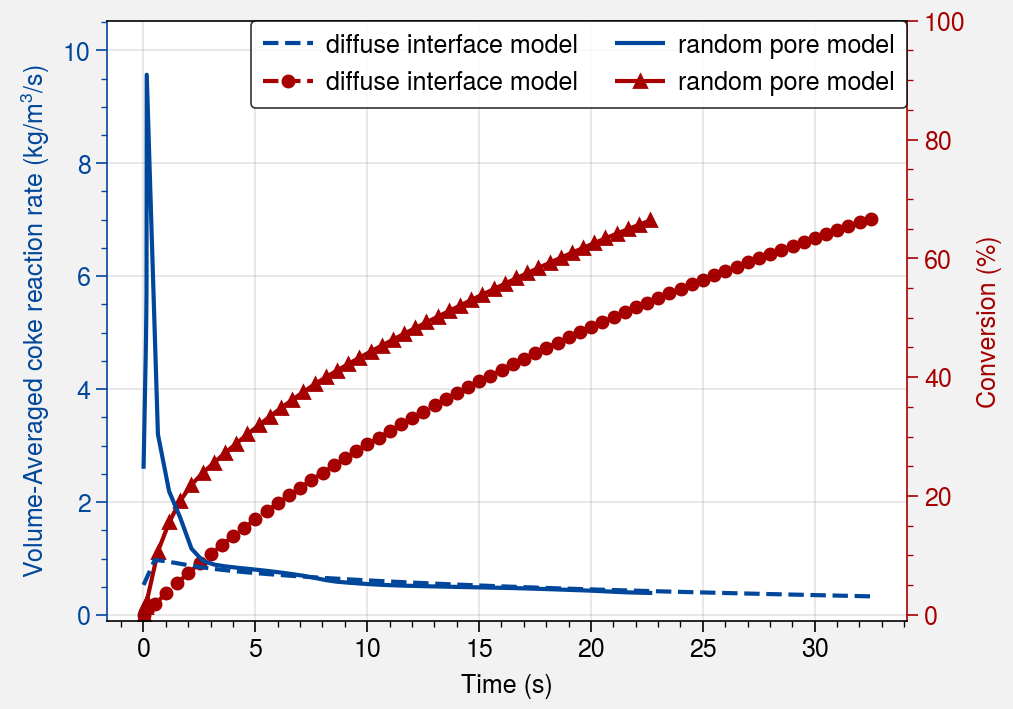

In [3]:
fig, ax = plot.subplots( aspect=(4, 3), axwidth=4)
c1 = plot.scale_luminance('cerulean', 0.5)
c2 = plot.scale_luminance('red', 0.5)

lns1=ax.plot(df_rate_external["time"],df_rate_external["vol_averaged_reaction_rate"],color=c1, label="diffuse interface model",ls="--")
lns1_2=ax.plot(df_rate_rpm["time"],df_rate_rpm["vol_averaged_reaction_rate"],color=c1, label="random pore model")

max_rate=df_rate_rpm["vol_averaged_reaction_rate"].max()
ax.format(xlabel="Time (s)",ylabel="Volume-Averaged coke reaction rate (kg/m$^3$/s)", ycolor=c1,ylim=(-0.1,max_rate*1.1))

ax2 = ax.twinx()
lns2=ax2.plot(df_rate_external["time"],df_rate_external["burning_fraction"]*100,color=c2,label="diffuse interface model",ls="--",marker="o",ms=4)
lns2_2=ax2.plot(df_rate_rpm["time"],df_rate_rpm["burning_fraction"]*100,color=c2,label="random pore model",marker="^",ms=4)
ax2.format(xlabel="Time (s)",ylabel="Conversion (%)",ycolor=c2,
            ylim=(-1,100))
        
lns = lns1+lns1_2+lns2+lns2_2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper right", ncol=2,fancybox=True)

In [4]:
fig.savefig("ReactionRateAndBurningRate2.jpg",bbox_inches='tight')

In [5]:
file_path_external="/home/anoldfriend/OpenFOAM/anoldfriend-7/run/cokeCombustion/T673_Pe1e-3_ExternalSurface/postProcessing/minMaxComponents2/32.51/fieldMinMax.dat"
transverse_data_folder_external="/home/anoldfriend/OpenFOAM/anoldfriend-7/run/cokeCombustion/T673_Pe1e-3_ExternalSurface/postProcess/transverseAveragedData"
df_combined_external=pyCompute.computeMaxTemperatureAndOutletO2ConcHistory(file_path_external,transverse_data_folder_external)
df_combined_external.head()

,Time,max,Transverse_Tmax,O2ConcAtOutlet
0,0.01,673.946,673.618186,0.000003
1,0.51,681.828,681.480817,0.524387
2,1.01,684.810,684.599014,0.398021
3,1.51,687.205,687.081288,0.332884
4,2.01,689.224,689.128461,0.300483


In [6]:
file_path_rpm="/home/anoldfriend/OpenFOAM/anoldfriend-7/run/cokeCombustion/T673_Pe1e-3_modifiedRPM/postProcessing/minMaxComponents2/22.65/fieldMinMax.dat"
transverse_data_folder_rpm="/home/anoldfriend/OpenFOAM/anoldfriend-7/run/cokeCombustion/T673_Pe1e-3_modifiedRPM/postProcess/transverseAveragedData"
df_combined_rpm=pyCompute.computeMaxTemperatureAndOutletO2ConcHistory(file_path_rpm,transverse_data_folder_rpm)
df_combined_rpm.head()

,Time,max,Transverse_Tmax,O2ConcAtOutlet
0,0.01,684.803,677.014587,0.000001
1,0.11,728.177,695.618583,0.002330
2,0.12,736.016,697.294426,0.002213
3,0.13,746.540,699.090897,0.002108
4,0.14,763.273,701.113806,0.002019


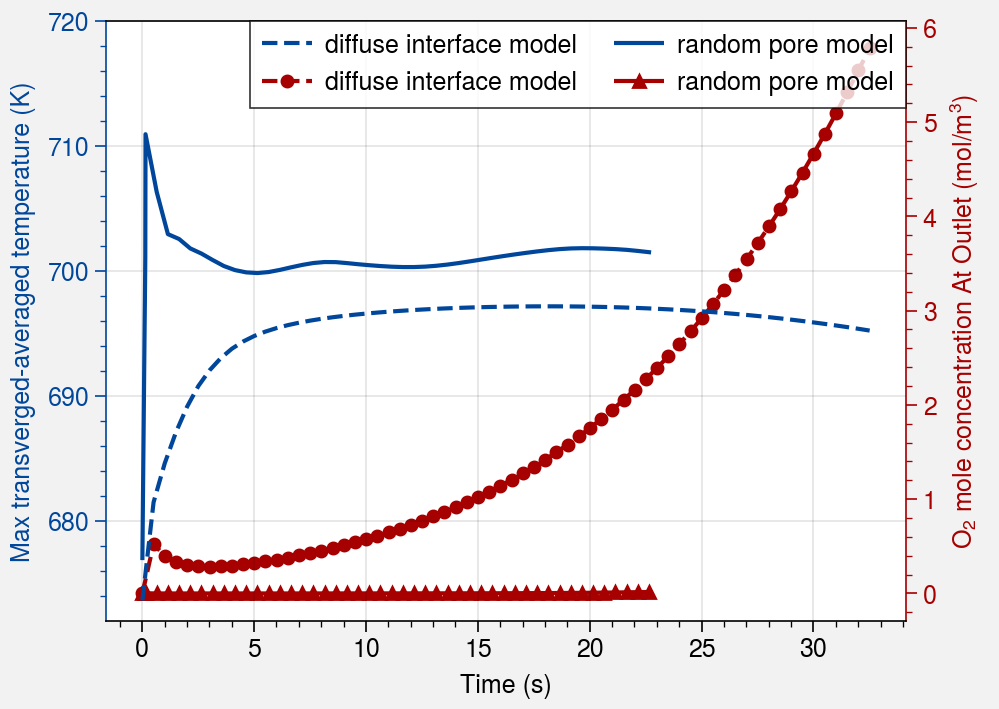

In [7]:
fig, ax = plot.subplots( aspect=(4, 3), axwidth=4)

lns1=ax.plot(df_combined_external["Time"],df_combined_external["Transverse_Tmax"],color=c1,label="diffuse interface model",linestyle="--")
lns1_2=ax.plot(df_combined_rpm["Time"],df_combined_rpm["Transverse_Tmax"],color=c1,label="random pore model",linestyle="-")
ax.format(xlabel="Time (s)",ylabel="Max transverged-averaged temperature (K)",ycolor=c1,ylim=(672,720))

ax2 = ax.twinx()
lns2= ax2.plot(df_combined_external["Time"],df_combined_external["O2ConcAtOutlet"],color=c2,linestyle="--",label="diffuse interface model",marker="o",ms=4)
lns2_2= ax2.plot(df_combined_rpm["Time"],df_combined_rpm["O2ConcAtOutlet"],color=c2,linestyle="-",label="random pore model",marker="^",ms=4)
max_O2=df_combined_external["O2ConcAtOutlet"].max()
ax2.format(xlabel="Time (s)",ylabel="O$_2$ mole concentration At Outlet (mol/m$^3$)", ycolor=c2)

lns = lns1+lns1_2+lns2+lns2_2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs,loc="upper right",  ncol=2, fancybox=False)



In [8]:
fig.savefig("MaxTransverseTemperature_OutletO2ConcHistory2.jpg",bbox_inches='tight')

In [9]:
maxT_file_external="/home/anoldfriend/OpenFOAM/anoldfriend-7/run/cokeCombustion/T673_Pe1e-3_ExternalSurface/postProcessing/minMaxComponents/0.01/fieldMinMax.dat"
maxT_file_rpm="/home/anoldfriend/OpenFOAM/anoldfriend-7/run/cokeCombustion/T673_Pe1e-3_modifiedRPM/postProcessing/minMaxComponents/0.15/fieldMinMax_0.1500012.dat"

maxT_external=pyFigure.read_min_max_field(maxT_file_external,100,"T")
maxT_rpm=pyFigure.read_min_max_field(maxT_file_rpm,100,"T")


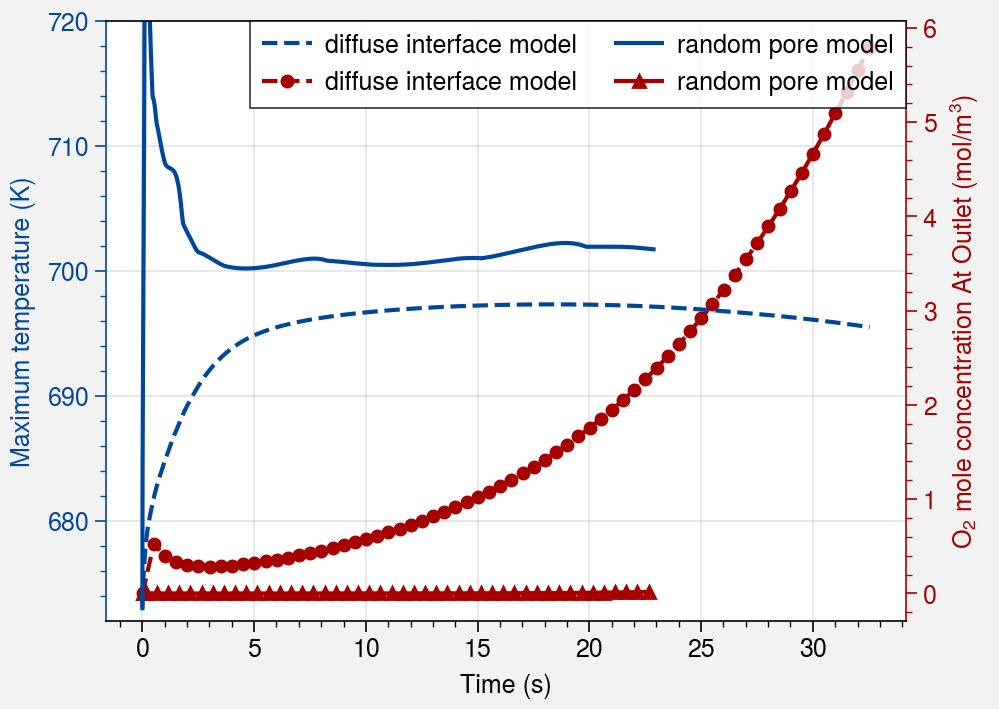

In [10]:
fig, ax = plot.subplots( aspect=(4, 3), axwidth=4)

lns1=ax.plot(maxT_external["Time"],maxT_external["max"],color=c1,label="diffuse interface model",linestyle="--")
lns1_2=ax.plot(maxT_rpm["Time"],maxT_rpm["max"],color=c1,label="random pore model",linestyle="-")
ax.format(xlabel="Time (s)",ylabel="Maximum temperature (K)",ycolor=c1,ylim=(672,720))

ax2 = ax.twinx()
lns2= ax2.plot(df_combined_external["Time"],df_combined_external["O2ConcAtOutlet"],color=c2,linestyle="--",label="diffuse interface model",marker="o",ms=4)
lns2_2= ax2.plot(df_combined_rpm["Time"],df_combined_rpm["O2ConcAtOutlet"],color=c2,linestyle="-",label="random pore model",marker="^",ms=4)
max_O2=df_combined_external["O2ConcAtOutlet"].max()
ax2.format(xlabel="Time (s)",ylabel="O$_2$ mole concentration At Outlet (mol/m$^3$)", ycolor=c2)

lns = lns1+lns1_2+lns2+lns2_2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs,loc="upper right",  ncol=2, fancybox=False)



In [11]:
fig.savefig("MaxTemperature_OutletO2ConcHistory2.jpg",bbox_inches='tight')

## plot contours

### RPM

In [12]:
rawData_rpm="/home/anoldfriend/OpenFOAM/anoldfriend-7/run/cokeCombustion/T673_Pe1e-3_modifiedRPM/postProcess/rawdata"
savefolder_rpm="/home/anoldfriend/OpenFOAM/anoldfriend-7/run/cokeCombustion/reactionSurfaceModel/rpm_images2"

fields=["eps","O2Conc","Qdot","T"]
xranges={"T":{"vmin":673,"vmax":701},
         "Qdot":{"vmin":0,"vmax":2.8e9}}
time_instant="10.15"
pyFigure.read_plot_multiple_field_contourf_save(rawData_rpm,fields,time_instant,savefolder_rpm,xranges)

/home/anoldfriend/OpenFOAM/anoldfriend-7/utilities/postProcess/pyFigure.py:102: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig = CS.ax.get_figure()


In [24]:
rawData_rpm="/home/anoldfriend/OpenFOAM/anoldfriend-7/run/cokeCombustion/T673_Pe1e-3_ExternalSurface/postProcess/rawdata"
savefolder_rpm="/home/anoldfriend/OpenFOAM/anoldfriend-7/run/cokeCombustion/reactionSurfaceModel/external_images"

fields=["eps","O2Conc","Qdot","T"]
xranges={"T":{"vmin":673,"vmax":701},
         "Qdot":{"vmin":0,"vmax":2.8e9}}
time_instant="10.01"
pyFigure.read_plot_multiple_field_contourf_save(rawData_rpm,fields,time_instant,savefolder_rpm,xranges)